<a href="https://colab.research.google.com/github/harperd17/energy_volatility_prediction/blob/main/notebooks/Data%20Ingestion/Weather_Data_Aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal: Aggregate the weather data to a state level.

In [ ]:
!pip install us
import us
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/Shareddrives/Data606_Energy/data/weather

/content/drive/Shareddrives/Data606_Energy/data/weather


In [ ]:
# this is temperature data
temp_df = pd.read_csv('temperatures_1981-01-01-2021-10-01.csv')
# population density data but at the coordinates in the temperature data
pop_temp_df = pd.read_csv('population_density_at_temperature_coordinates.csv')
# drought data
pdsi_df = pd.read_csv('pdsi_1981-01-01-2021-10-01.csv')
# population density data but at the coordinates in the drought data
pop_drought_df = pd.read_csv('population_density_at_drought_coordinates.csv')

In [ ]:
# convert the states from entire names to abbreviations
pop_temp_df['State'] = [us.states.lookup(s).abbr for s in temp_df['State']]

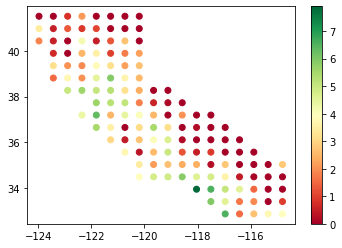

In [ ]:
# just to show a sample of what this log density stuff looks like
ca_pop = pop_temp_df[(pop_temp_df['State']=='CA')]#&(pop_temp_df['Average Density']>15)]
plt.scatter(ca_pop['x'],ca_pop['y'],c=np.log(np.maximum(np.ones(ca_pop.shape[0]),np.array(ca_pop['Average Density']))),cmap='RdYlGn')
plt.colorbar()

## Function to convert a dataframes values into standardardized values based on historical mean and standard deviation. Returns the standardized values as well as the means and standard deviations

In [ ]:
def standardize_data(data,date_start):
  # first, I need to create an array that holds the average as time goes by during the time range of interest
  # I need to do the same thing with the standard deviations
  cols = data.columns[1:-3] # excluding 1st column and last 3
  cols = pd.to_datetime(cols,format='%Y-%m-%d')
  data.columns = ['Untitled']+list(cols)+['y','x','State']
  cols_for_average = cols[cols<date_start]
  df_for_average = data.copy()[cols_for_average]
  # specify which columns are to be standardized
  cols_for_analysis = cols[cols>=date_start]
  data_for_analysis = data.copy()[cols_for_analysis]
  # grab the averages and standard deviations by coordinate and by month
  month_summaries = {}
  for m in range(1,13):
    month_columns = cols_for_average[[col.month == m for col in cols_for_average]]
    month_avgs = df_for_average[month_columns].mean(axis=1)
    month_stds = df_for_average[month_columns].std(axis=1)
    month_summaries[f'Averages {m}'] = month_avgs
    month_summaries[f'Standard Deviations {m}'] = month_stds
    month_columns_standardize = cols_for_analysis[[col.month == m for col in cols_for_analysis]]
    # now standardize the data used for analysis using these averages and standard deviations
    for col in month_columns_standardize:
      data_for_analysis[col] = (data_for_analysis[col]-month_avgs)/month_stds
  data_for_analysis[['y','x','State']] = data[['y','x','State']]
  month_summaries['x']=data_for_analysis['x']
  month_summaries['y']=data_for_analysis['y']
  month_summaries['State']=data_for_analysis['State']
  return data_for_analysis, pd.DataFrame(month_summaries)

### Get convert data from 2000 onward into standard deviations above average

In [ ]:
standardized_temperatures, temp_summary = standardize_data(temp_df,'2000-01-01')
standardized_droughts, drought_summary = standardize_data(pdsi_df,'2000-01-01')

In [ ]:
# this is the average and standard deviation for every location
# temp_summary.to_csv('temp_summary_all_locations.csv')
# drought_summary.to_csv('drought_summary_all_locations.csv')

In [ ]:
# first I need to make the column names into datetimes so that I can subset stuff on months
date_cols = standardized_temperatures.columns[:-3] # emit the last 3 cause they're coordinates and States
date_cols = pd.to_datetime(date_cols,format='%Y-%m-%d')
standardized_temperatures.columns = list(date_cols)+['y','x','State']
# standardize each of the dataframes
date_cols = standardized_droughts.columns[:-3] # emit the last 3 cause they're coordinates and States
date_cols = pd.to_datetime(date_cols,format='%Y-%m-%d')
standardized_droughts.columns = list(date_cols)+['y','x','State']

In [ ]:
standardized_temperatures.head()

,2000-01-01 00:00:00,2000-02-01 00:00:00,2000-03-01 00:00:00,2000-04-01 00:00:00,2000-05-01 00:00:00,2000-06-01 00:00:00,2000-07-01 00:00:00,2000-08-01 00:00:00,2000-09-01 00:00:00,2000-10-01 00:00:00,2000-11-01 00:00:00,2000-12-01 00:00:00,2001-01-01 00:00:00,2001-02-01 00:00:00,2001-03-01 00:00:00,2001-04-01 00:00:00,2001-05-01 00:00:00,2001-06-01 00:00:00,2001-07-01 00:00:00,2001-08-01 00:00:00,2001-09-01 00:00:00,2001-10-01 00:00:00,2001-11-01 00:00:00,2001-12-01 00:00:00,2002-01-01 00:00:00,2002-02-01 00:00:00,2002-03-01 00:00:00,2002-04-01 00:00:00,2002-05-01 00:00:00,2002-06-01 00:00:00,2002-07-01 00:00:00,2002-08-01 00:00:00,2002-09-01 00:00:00,2002-10-01 00:00:00,2002-11-01 00:00:00,2002-12-01 00:00:00,2003-01-01 00:00:00,2003-02-01 00:00:00,2003-03-01 00:00:00,2003-04-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,y,x,State
0,0.195069,0.008212,0.542134,-0.099071,-1.263220,1.355255,-1.355001,-0.156775,0.295289,0.336192,0.231562,0.965054,0.539950,1.417825,-0.235910,0.161477,-1.733667,0.276314,-0.940999,-0.949220,0.459242,-0.693373,0.535062,0.368379,-0.795404,-0.496381,2.568848,0.355922,1.238312,-0.766687,-0.494775,-0.033940,1.455358,1.350557,1.228551,2.029864,0.779507,-0.382636,0.047932,1.272985,...,-2.106060,0.775329,-0.842690,1.385419,1.903498,1.316913,0.570158,0.383676,2.080495,3.560159,0.635884,1.254443,0.187068,2.321077,0.959672,2.646459,2.240785,2.096054,1.275728,-0.416964,-1.575853,1.155236,1.010875,0.238713,0.366593,-1.750719,1.230021,1.166424,1.705080,2.059590,1.300329,0.531345,-1.220812,0.349684,0.345036,0.179930,0.320230,71.146571,-156.845849,Alaska
1,0.229799,0.084691,0.570635,-0.121588,-1.269277,1.982208,-0.923468,0.000120,0.322423,0.312269,0.213154,0.997385,0.518398,1.377912,-0.296399,0.153562,-1.820193,0.522424,-0.817209,-0.799934,0.440162,-0.760378,0.558782,0.301605,-0.847112,-0.582006,2.452279,0.346559,1.143007,-0.493047,-0.842272,0.274886,1.492715,1.316731,1.215640,2.106060,0.763110,-0.441068,-0.035193,1.190013,...,-2.016151,1.278024,-0.793160,1.343480,1.814703,1.288897,0.561481,0.324017,2.035533,3.486195,0.632646,1.262242,-0.397942,2.288377,1.211037,2.763874,2.211329,2.070737,1.244128,-0.343043,-1.615594,1.112115,0.994381,0.206089,-0.076209,-1.650540,1.330749,1.233127,1.602910,2.064603,1.249781,0.449425,-1.286125,0.322851,0.254289,0.255888,0.199475,71.146571,-156.306859,Alaska
2,0.213839,0.142913,0.633141,-0.123425,-1.264391,1.925228,-0.923456,-0.078843,0.275176,0.277998,0.252611,1.038400,0.565449,1.360920,-0.281803,0.126567,-1.838874,0.492469,-0.816983,-0.790820,0.442558,-0.725390,0.560192,0.270207,-0.870147,-0.543279,2.428608,0.346430,1.165701,-0.388580,-0.856394,0.221360,1.488662,1.273068,1.265913,2.125463,0.766742,-0.354093,0.002695,1.170158,...,-2.122100,1.285869,-0.894485,1.289650,1.803027,1.323934,0.676521,0.416652,2.060172,3.590126,0.644761,1.242324,-0.331961,2.097792,0.938290,2.683797,2.150591,1.984693,1.189231,-0.352041,-1.580315,1.136193,0.968015,0.162689,-0.068007,-1.732740,1.103848,1.178243,1.622070,2.049627,1.370200,0.490209,-1.221262,0.375662,0.278977,0.250552,0.245440,71.146571,-155.767870,Alaska
3,-0.058758,0.154317,0.210616,0.011210,-1.261560,0.198878,-2.229658,-0.417110,0.102771,0.278783,0.225094,0.802836,0.509141,1.428701,-0.127763,0.036756,-1.837890,-0.819211,-1.850839,-1.030695,0.650

In [ ]:
# first make sure the coordinates match up so I can add the population density as a column to the temperature and drought dataframes
print(sum(standardized_temperatures['y'] != pop_temp_df['y']))
print(sum(standardized_droughts['y'] != pop_drought_df['y']))

0
0


In [ ]:
# bring over the population densities per location
standardized_temperatures['Population Density'] = pop_temp_df['Average Density']
standardized_droughts['Population Density'] = pop_drought_df['Average Density']

# Final Data That I want is:
For each of these data items, I want it both at a location level and state level
1. average value from 1981-2000
2. standard deviation from 1981-2000
3. standardized value by month
4. population density

In [ ]:
final_temp_data_summary_location = temp_summary.copy()
final_temp_data_temporal_location = standardized_temperatures.copy()
final_temp_data_summary_location['State'] = [us.states.lookup(s).abbr for s in final_temp_data_summary_location['State']]
final_temp_data_temporal_location['State'] = [us.states.lookup(s).abbr for s in final_temp_data_temporal_location['State']]

final_drought_data_summary_location = drought_summary.copy()
final_drought_data_temporal_location = standardized_droughts.copy()
final_drought_data_summary_location['State'] = [us.states.lookup(s).abbr for s in final_drought_data_summary_location['State']]
final_drought_data_temporal_location['State'] = [us.states.lookup(s).abbr for s in final_drought_data_temporal_location['State']]

In [ ]:
print((final_temp_data_summary_location[['x','y']] != final_temp_data_temporal_location[['x','y']]).sum())
print((final_drought_data_summary_location[['x','y']] != final_drought_data_temporal_location[['x','y']]).sum())

x    0
y    0
dtype: int64
x    0
y    0
dtype: int64


In [ ]:
# add the population density
final_temp_data_summary_location['Population Density'] = list(final_temp_data_temporal_location['Population Density'])
final_drought_data_summary_location['Population Density'] = list(final_drought_data_temporal_location['Population Density'])

In [ ]:
# drop any na values
final_temp_data_summary_location = final_temp_data_summary_location.dropna()
final_drought_data_summary_location = final_drought_data_summary_location.dropna()
final_temp_data_temporal_location = final_temp_data_temporal_location.dropna()
final_drought_data_temporal_location = final_drought_data_temporal_location.dropna()

In [ ]:
def format_temporal_data(df,value_col_name):
  # first find out which columns are dates
  temporal_columns = []
  for col in df.columns:
    try:
      col.year
      temporal_columns.append(col)
    except:
      ...
  # go through each row and turn that into extra rows for every date column
  dates = []
  values = []
  xs = []
  ys = []
  states = []
  for i in range(df.shape[0]):
    dates += temporal_columns
    values += list(df[temporal_columns].iloc[i])
    xs += [df['x'].iloc[i]]*len(temporal_columns)
    ys += [df['y'].iloc[i]]*len(temporal_columns)
    states += [df['State'].iloc[i]]*len(temporal_columns)
  new_df = pd.DataFrame({value_col_name:values,'x':xs,'y':ys,'State':states},index=dates)
  new_df['Month'] = new_df.index.month
  new_df['Year'] = new_df.index.year
  # # now pivot the dataframe to have one column per month
  new_df['coord state year'] = list(zip(new_df['x'], new_df['y'], new_df['State'],new_df['Year']))
  pivoted_df = pd.pivot(new_df,index='coord state year',columns='Month',values=value_col_name).reset_index()
  pivoted_df[['x','y','State','Year']] = pivoted_df['coord state year'].to_list()
  del pivoted_df['coord state year']
  new_columns = []
  for col in pivoted_df.columns:
    try:
      int(col)
      new_columns.append(value_col_name+str(col))
    except:
      new_columns.append(col)
  pivoted_df.columns = new_columns
  return pivoted_df

In [ ]:
pivoted_temp_temporal = format_temporal_data(final_temp_data_temporal_location,'Standardized Temp ')
pivoted_drought_temporal = format_temporal_data(final_drought_data_temporal_location,'Standardized Drought ')

# Now group these dataframes by state

In [ ]:
final_temp_data_summary_state = final_temp_data_summary_location.groupby(by='State').mean().reset_index()
final_drought_data_summary_state = final_drought_data_summary_location.groupby(by='State').mean().reset_index()

In [ ]:
final_temp_data_temporal_state = pivoted_temp_temporal.groupby(by=['State','Year']).mean().reset_index()
final_drought_data_temporal_state = pivoted_drought_temporal.groupby(by=['State','Year']).mean().reset_index()

# Merge the state dataframes together

In [ ]:
new_columns = []
for col in final_temp_data_summary_state.columns:
  if 'Average' in col or 'Standard' in col:
    new_columns.append('Temp '+col)
  else:
    new_columns.append(col)
final_temp_data_summary_state.columns = new_columns


new_columns = []
for col in final_drought_data_summary_state.columns:
  if 'Average' in col or 'Standard' in col:
    new_columns.append('PDSI '+col)
  else:
    new_columns.append(col)
final_drought_data_summary_state.columns = new_columns

In [ ]:
# merge the final temp data summary state
del final_drought_data_temporal_state['x']
del final_drought_data_temporal_state['y']
all_state_data = pd.merge(final_temp_data_temporal_state,final_drought_data_temporal_state,on=['Year','State'])
del final_temp_data_summary_state['x']
del final_temp_data_summary_state['y']
all_state_data = pd.merge(all_state_data,final_temp_data_summary_state, on='State')
del final_drought_data_summary_state['x']
del final_drought_data_summary_state['y']
del final_drought_data_summary_state['Population Density']
all_state_data = pd.merge(all_state_data,final_drought_data_summary_state, on='State')

In [ ]:
all_state_data.head()

,State,Year,Standardized Temp 1,Standardized Temp 2,Standardized Temp 3,Standardized Temp 4,Standardized Temp 5,Standardized Temp 6,Standardized Temp 7,Standardized Temp 8,Standardized Temp 9,Standardized Temp 10,Standardized Temp 11,Standardized Temp 12,x,y,Standardized Drought 1,Standardized Drought 2,Standardized Drought 3,Standardized Drought 4,Standardized Drought 5,Standardized Drought 6,Standardized Drought 7,Standardized Drought 8,Standardized Drought 9,Standardized Drought 10,Standardized Drought 11,Standardized Drought 12,Temp Averages 1,Temp Standard Deviations 1,Temp Averages 2,Temp Standard Deviations 2,Temp Averages 3,Temp Standard Deviations 3,Temp Averages 4,Temp Standard Deviations 4,Temp Averages 5,Temp Standard Deviations 5,Temp Averages 6,Temp Standard Deviations 6,Temp Averages 7,Temp Standard Deviations 7,Temp Averages 8,Temp Standard Deviations 8,Temp Averages 9,Temp Standard Deviations 9,Temp Averages 10,Temp Standard Deviations 10,Temp Averages 11,Temp Standard Deviations 11,Temp Averages 12,Temp Standard Deviations 12,Population Density,PDSI Averages 1,PDSI Standard Deviations 1,PDSI Averages 2,PDSI Standard Deviations 2,PDSI Averages 3,PDSI Standard Deviations 3,PDSI Averages 4,PDSI Standard Deviations 4,PDSI Averages 5,PDSI Standard Deviations 5,PDSI Averages 6,PDSI Standard Deviations 6,PDSI Averages 7,PDSI Standard Deviations 7,PDSI Averages 8,PDSI Standard Deviations 8,PDSI Averages 9,PDSI Standard Deviations 9,PDSI Averages 10,PDSI Standard Deviations 10,PDSI Averages 11,PDSI Standard Deviations 11,PDSI Averages 12,PDSI Standard Deviations 12
0,AK,2000,-0.351759,1.265791,0.605999,-0.010856,-1.171727,0.323591,-1.204733,-1.232359,-0.542109,0.135794,1.455481,1.000056,-152.519813,64.570432,-0.315524,-0.422336,-0.473529,-0.580449,-0.566660,-0.702407,-0.253609,0.020098,0.311207,0.282454,0.377485,0.221861,253.901962,4.56224,254.912898,4.604932,259.895423,2.913379,267.10453,3.020624,275.702611,2.031912,282.768756,1.159624,285.381392,1.246759,282.592454,1.421056,276.548678,2.200508,266.098318,2.585909,257.715494,2.952326,255.386289,3.535675,0.2917,42.843985,270.09766,48.6501,248.828078,39.985405,251.81558,11.605982,237.676486,1.340004,229.673345,-22.444825,238.009842,-22.957154,251.567166,8.770732,257.518698,28.190458,265.850022,29.876769,270.785332,31.834476,278.537078,34.692393,280.18913
1,AK,2001,1.183247,1.142341,-0.364490,0.025871,-1.833719,0.017329,-1.358290,0.158174,0.596640,-0.656565,-0.239989,-1.002076,-152.519813,64.570432,0.166994,0.415456,0.277527,0.434879,0.375641,-0.069283,0.539778,0.549674,0.042327,-0.027238,-0.355502,-0.635643,253.901962,4.56224,254.912898,4.604932,259.895423,2.913379,267.10453,3.020624,275.702611,2.031912,282.768756,1.159624,285.381392,1.246759,282.592454,1.421056,276.548678,2.200508,266.098318,2.585909,257.715494,2.952326,255.386289,3.535675,0.2917,42.843985,270.09766,48.6501,248.828078,39.985405,251.81558,11.605982,237.676486,1.340004,229.673345,-22.444825,238.009842,-22.957154,251.567166,8.770732,257.518698,28.190458,265.850022,29.876769,270.785332,31.834476,278.537078,34.692393,280.18913
2,AK,2002,0.460926,0.242467,0.352463,-0.542252,0.301593,-0.236632,-0.461110,-0.075577,0.615888,1.860387,2.548320,1.078300,-152.519813,64.570432,-0.519207,-0.701951,-0.802648,-0.626576,-0.860459,-0.979448,-0.942735,-0.993685,-0.697794,-0.477562,-0.544642,-0.669233,253.901962,4.56224,254.912898,4.604932,259.895423,2.913379,267.10453,3.020624,275.702611,2.031912,282.768756,1.159624,285.381392,1.246759,282.592454,1.421056,276.548678,2.200508,266.098318,2.585909,257.715494,2.952326,255.386289,3.535675,0.2917,42.843985,270.09766,48.6501,248.828078,39.985405,251.81558,11.605982,237.676486,1.340004,229.673345,-22.444825,238.009842,-22.957154,251.567166,8.770732,257.518698,28.190458,265.850022,29.876769,270.785332,31.834476,278.537078,34.692393,280.18913
3,AK,2003,0.640511,1.255819,-0.482539,0.577030,-0.150032,0.528172,-0.368404,0.230696,-0.450399,1.890428,0.906217,-0.378229,-152.519813,64.57

In [ ]:
all_state_data.to_csv('../merge_ready/annual_weather_final.csv')

# Now merge together the dataframes with data for all locations

In [ ]:
new_columns = []
for col in final_temp_data_summary_location.columns:
  if 'Average' in col or 'Standard' in col:
    new_columns.append('Temp '+col)
  else:
    new_columns.append(col)
final_temp_data_summary_location.columns = new_columns


new_columns = []
for col in final_drought_data_summary_location.columns:
  if 'Average' in col or 'Standard' in col:
    new_columns.append('PDSI '+col)
  else:
    new_columns.append(col)
final_drought_data_summary_location.columns = new_columns

In [ ]:
# now add in the summaries
del final_temp_data_summary_location['State']
all_temp_location = pd.merge(pivoted_temp_temporal,final_temp_data_summary_location,on=['x','y'])

In [ ]:
# now add in the summaries
del final_drought_data_summary_location['State']
all_drought_location = pd.merge(pivoted_drought_temporal,final_drought_data_summary_location,on=['x','y'])

In [ ]:
all_temp_location.head()

,Standardized Temp 1,Standardized Temp 2,Standardized Temp 3,Standardized Temp 4,Standardized Temp 5,Standardized Temp 6,Standardized Temp 7,Standardized Temp 8,Standardized Temp 9,Standardized Temp 10,Standardized Temp 11,Standardized Temp 12,x,y,State,Year,Temp Averages 1,Temp Standard Deviations 1,Temp Averages 2,Temp Standard Deviations 2,Temp Averages 3,Temp Standard Deviations 3,Temp Averages 4,Temp Standard Deviations 4,Temp Averages 5,Temp Standard Deviations 5,Temp Averages 6,Temp Standard Deviations 6,Temp Averages 7,Temp Standard Deviations 7,Temp Averages 8,Temp Standard Deviations 8,Temp Averages 9,Temp Standard Deviations 9,Temp Averages 10,Temp Standard Deviations 10,Temp Averages 11,Temp Standard Deviations 11,Temp Averages 12,Temp Standard Deviations 12,Population Density
0,-0.957011,1.200884,0.800751,-0.243718,-0.213196,-0.197819,-0.486909,-0.020221,-0.095478,0.537595,1.118781,2.082065,-171.398556,63.600722,AK,2000,257.949309,3.40895,257.911034,4.921982,259.32886,3.386979,264.915547,2.94111,272.073747,1.327664,277.637399,0.738226,281.020701,0.71406,281.110063,1.063318,277.90725,1.181917,272.830723,1.044702,268.099073,2.417131,260.941729,4.208157,0.308097
1,0.779320,1.668876,-0.074322,0.018863,-1.448172,-0.942915,-1.865768,-0.928228,-0.203188,-1.820334,-0.341046,-1.425781,-171.398556,63.600722,AK,2001,257.949309,3.40895,257.911034,4.921982,259.32886,3.386979,264.915547,2.94111,272.073747,1.327664,277.637399,0.738226,281.020701,0.71406,281.110063,1.063318,277.90725,1.181917,272.830723,1.044702,268.099073,2.417131,260.941729,4.208157,0.308097
2,-1.221576,0.103127,2.312385,0.705747,1.428953,1.932424,0.116319,0.461213,1.377486,2.477561,1.128137,1.151197,-171.398556,63.600722,AK,2002,257.949309,3.40895,257.911034,4.921982,259.32886,3.386979,264.915547,2.94111,272.073747,1.327664,277.637399,0.738226,281.020701,0.71406,281.110063,1.063318,277.90725,1.181917,272.830723,1.044702,268.099073,2.417131,260.941729,4.208157,0.308097
3,0.745436,-0.426555,0.542318,1.556103,0.957247,1.948112,0.303362,0.130987,1.090570,1.123203,0.669912,0.091806,-171.398556,63.600722,AK,2003,257.949309,3.40895,257.911034,4.921982,259.32886,3.386979,264.915547,2.94111,272.073747,1.327664,277.637399,0.738226,281.020701,0.71406,281.110063,1.063318,277.90725,1.181917,272.830723,1.044702,268.099073,2.417131,260.941729,4.208157,0.308097
4,0.917958,-0.195304,0.601772,0.878760,1.733436,1.773723,3.147134,2.433600,0.597206,2.451490,0.808995,0.610390,-171.398556,63.600722,AK,2004,257.949309,3.40895,257.911034,4.921982,259.32886,3.386979,264.915547,2.94111,272.073747,1.327664,277.637399,0.738226,281.020701,0.71406,281.110063,1.063318,277.90725,1.181917,272.830723,1.044702,268.099073,2.417131,260.941729,4.208157,0.308097


In [ ]:
all_drought_location.head()

,Standardized Drought 1,Standardized Drought 2,Standardized Drought 3,Standardized Drought 4,Standardized Drought 5,Standardized Drought 6,Standardized Drought 7,Standardized Drought 8,Standardized Drought 9,Standardized Drought 10,Standardized Drought 11,Standardized Drought 12,x,y,State,Year,PDSI Averages 1,PDSI Standard Deviations 1,PDSI Averages 2,PDSI Standard Deviations 2,PDSI Averages 3,PDSI Standard Deviations 3,PDSI Averages 4,PDSI Standard Deviations 4,PDSI Averages 5,PDSI Standard Deviations 5,PDSI Averages 6,PDSI Standard Deviations 6,PDSI Averages 7,PDSI Standard Deviations 7,PDSI Averages 8,PDSI Standard Deviations 8,PDSI Averages 9,PDSI Standard Deviations 9,PDSI Averages 10,PDSI Standard Deviations 10,PDSI Averages 11,PDSI Standard Deviations 11,PDSI Averages 12,PDSI Standard Deviations 12,Population Density
0,0.986234,1.387622,1.253549,0.843595,0.912461,0.864735,0.844439,0.859910,0.794851,0.546735,0.612239,0.529862,-170.320578,63.600722,AK,2000,-30.473684,265.123319,-7.894737,249.992199,11.842105,246.626182,14.105263,239.326577,-11.0,229.05094,-49.473684,223.737537,-91.631579,242.328338,-34.894737,261.532852,-28.368421,289.82585,-3.526316,300.925123,5.315789,293.487091,10.789474,277.828,0.478685
1,0.654313,0.783603,0.365565,0.500967,0.419121,0.091508,0.064506,-0.401882,-0.488678,-0.593083,-0.866531,-1.075448,-170.320578,63.600722,AK,2001,-30.473684,265.123319,-7.894737,249.992199,11.842105,246.626182,14.105263,239.326577,-11.0,229.05094,-49.473684,223.737537,-91.631579,242.328338,-34.894737,261.532852,-28.368421,289.82585,-3.526316,300.925123,5.315789,293.487091,10.789474,277.828,0.478685
2,-0.967574,-0.988452,-0.976547,-0.902972,-0.973583,-1.137611,-1.132218,-1.889267,-1.761857,-2.071857,-2.389597,-2.569178,-170.320578,63.600722,AK,2002,-30.473684,265.123319,-7.894737,249.992199,11.842105,246.626182,14.105263,239.326577,-11.0,229.05094,-49.473684,223.737537,-91.631579,242.328338,-34.894737,261.532852,-28.368421,289.82585,-3.526316,300.925123,5.315789,293.487091,10.789474,277.828,0.478685
3,-2.419728,-2.380495,-2.355152,-1.976819,-1.855482,-1.508582,-1.313789,-1.457198,-1.665247,-2.081826,-2.345302,-2.468396,-170.320578,63.600722,AK,2003,-30.473684,265.123319,-7.894737,249.992199,11.842105,246.626182,14.105263,239.326577,-11.0,229.05094,-49.473684,223.737537,-91.631579,242.328338,-34.894737,261.532852,-28.368421,289.82585,-3.526316,300.925123,5.315789,293.487091,10.789474,277.828,0.478685
4,-2.468762,-2.544500,-2.436246,-2.382123,-2.401213,-2.330974,-2.378461,-2.485750,-2.538185,-2.683304,-2.931358,-3.055090,-170.320578,63.600722,AK,2004,-30.473684,265.123319,-7.894737,249.992199,11.842105,246.626182,14.105263,239.326577,-11.0,229.05094,-49.473684,223.737537,-91.631579,242.328338,-34.894737,261.532852,-28.368421,289.82585,-3.526316,300.925123,5.315789,293.487091,10.789474,277.828,0.478685


In [ ]:
all_temp_location.to_csv('temp_data_by_location.csv')
all_drought_location.to_csv('drought_data_by_location.csv')

# Now make a metric that is number of months with heat, cold, and drought by time of year

In [ ]:
temperature_mean_grouped = standardized_temperatures.groupby(by='State').mean()
drought_mean_grouped = standardized_droughts.groupby(by='State').mean()

In [ ]:
# since this is now getting aggregated at the annual level, I need to somehow capture monthly granularity
# I will create a summer dataset which has the number of months with summer temperatures above 1 std above the mean
# likewise for winter but with 1 std below the mean
# do the same thing for droughts but only for the 1 standard deviation below since low values correspond to droughts
temps_1_above = temperature_mean_grouped.copy()
temps_1_below = temperature_mean_grouped.copy()
droughts_1_below = drought_mean_grouped.copy()
for date_col in date_cols:
  month = date_col.month
  temps_1_above[date_col] = temps_1_above[date_col] >= 1
  temps_1_below[date_col] = temps_1_above[date_col] < 1
  droughts_1_below[date_col] = droughts_1_below[date_col] <= 1 

In [ ]:
summer_months = [6,7,8,9]
winter_months = [12,1,2,3]
years = []
states = []
temps_above = []
temps_below = []
droughts_below = []
# go through and filter by year and state and for each gather a count for the summer months 1 std above average and the winter months 1 std below average
for y in list(date_cols.year.unique()):
  for s in list(standardized_temperatures['State'].unique()):
    years.append(y)
    states.append(us.states.lookup(s).abbr)
    temps_above.append(temps_1_above[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][temps_1_above.index==s].sum().sum())
    temps_below.append(temps_1_below[date_cols[(date_cols.year==y)&(date_cols.month.isin(winter_months))]][temps_1_below.index==s].sum().sum())
    droughts_below.append(droughts_1_below[date_cols[(date_cols.year==y)&(date_cols.month.isin(summer_months))]][droughts_1_below.index==s].sum().sum())
annual_summary = pd.DataFrame({'State':states,'Year':years,'Hot Summer Months':temps_above,'Cold Winter Months':temps_below,'Dry Summer Months':droughts_below})

In [ ]:
annual_summary.head()

,State,Year,Hot Summer Months,Cold Winter Months,Dry Summer Months
0,AK,2000,0,2,4
1,MN,2000,0,3,4
2,WA,2000,0,4,4
3,ID,2000,1,4,4
4,MT,2000,0,4,4


In [ ]:
annual_summary.to_csv('annual_weather_derived.csv')